### Andrew Egelhof
### KSU  Data Analytics Capstone Class
### GENBA 894


# Data Modeling

## Text Analytics
For the "Description of Incident" field.

In [49]:
# import packages for text processing
import csv
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pyLDAvis.gensim

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)  # To ignore all warnings that arise here to enhance clarity

In [2]:
# load data
Data_Breaches = []

openfile = open("Datasets/Cleaned/Privacy_Rights_Cleaned.csv", "rb")
r = csv.reader(openfile)

for i in r:
    Data_Breaches.append(i)
openfile.close()

In [3]:
#convert to pandas    
Data_Breaches_DF = pd.DataFrame(Data_Breaches)

#set column names
Data_Breaches_DF.columns = ['Company','Year','Month','Day of Month','City','State', 'Country','Data_Public', 'Breach_Type','Org_Type','Total_Records','Description']
           
#set total_records to float datatype
Data_Breaches_DF['Total_Records'] = Data_Breaches_DF.Total_Records.astype(float)
    
#check data
Data_Breaches_DF.head(5)

,Company,Year,Month,Day of Month,City,State,Country,Data_Public,Breach_Type,Org_Type,Total_Records,Description
0,﻿1 Chat Avenue,2012,2,13,,Kansas,USA,2/13/2012,Hacking,Business Other,39.0,A hacker or hackers accessed and posted online...
1,101 Family Medical Group Privacy Manager Breach,2014,1,8,,California,USA,1/8/2014,Physical Loss,Medical Provider,2500.0,"A laptop computer owned by Phressia, Inc., a b..."
2,101Domaincom,2011,11,27,Carlsbad,California,USA,11/27/2011,Hacking,Business Other,10000.0,A phishing attack exposed the personal informa...
3,1800Flowers,2016,3,8,Carle Place,New York,USA,3/8/2016,Hacking,Business Other,0.0,1-800-Flowers customer service received report...
4,1st Mariner Bank,2018,2,5,Baltimore,Maryland,USA,2/5/2018,Hacking,Finance Or Insurance,1500.0,1st Mariner Bank experienced a phishing attack...


In [4]:
# put incident description into list
List_Descriptions = []

for i in Data_Breaches_DF['Description']:
    List_Descriptions.append(i)

In [5]:
#verify data by looking at a sample

for i in List_Descriptions[0:5]:
    print i


A hacker or hackers accessed and posted online information. Â A total of 39 administrator and moderator usernames, email addresses, and salted passwords were exposed.


Business associate present: Yes
A phishing attack exposed the personal information of users with domain names.Â  The unauthorized access was discovered by 101domain.com when a vendor contacted them to inform them of a breach that affected multiple vendors, including 101Domain.com.Â  UPDATE (12/20/2011): The websites 101domain.com, bluesit.com, free-domain.com, rerundomains.com, RWGUSA.com, and RWGUSA.net could have all been affected by a server breach at one of 101Domain, Inc.'s vendors.Â  Encrypted customer names, addresses, email addresses, and in some cases, credit card or PayPal account information could have been compromised.Â
1-800-Flowers customer service received reports on February 15, 2016 from customers that they couldn't complete their online orders. The company investigated and discovered from February 15th

### Text Pre-processing

In [6]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z0-9]+", " ", text) for text in List_Descriptions]

In [7]:
# tokenize
description_data = [[word for word in text.lower().split() ] for text in documents]

In [8]:
# stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
description_data = [[lmtzr.lemmatize(word) for word in text ] for text in description_data]

In [9]:
# remove common words 
more_stopwords = set(('would','said','also', 'like','many','way','say','know','may','000'))
stoplist = set(stopwords.words('english')) | more_stopwords
description_data = [[word for word in text if word not in stoplist] for text in description_data]

In [10]:
#remove short words
description_data = [[ word for word in tokens if len(word) >= 3 ] for tokens in description_data]

In [11]:
#make it into a flat list of data
description_data = [item for sublist in description_data for item in sublist]

### Word Frequencies / Bi Grams

In [12]:
#word freqeuncy distrobution
fdist_DD = nltk.FreqDist(description_data)
fdist_DD.most_common(50)

[('information', 13874),
 (u'number', 7275),
 ('security', 5130),
 ('breach', 5091),
 (u'name', 4656),
 ('employee', 3747),
 ('social', 3588),
 (u'address', 3161),
 ('business', 3017),
 (u'patient', 2888),
 ('health', 2825),
 ('associate', 2821),
 ('location', 2701),
 ('breached', 2682),
 ('affected', 2663),
 ('computer', 2522),
 ('present', 2479),
 (u'individual', 2478),
 (u'date', 2468),
 ('card', 2449),
 ('data', 2411),
 ('laptop', 2248),
 ('email', 1998),
 ('included', 1960),
 ('customer', 1958),
 ('credit', 1906),
 ('account', 1885),
 ('personal', 1855),
 (u'record', 1843),
 ('stolen', 1814),
 ('service', 1766),
 ('birth', 1749),
 ('medical', 1699),
 ('contained', 1582),
 ('ocr', 1511),
 ('access', 1456),
 ('system', 1446),
 ('company', 1424),
 ('provided', 1396),
 ('exposed', 1296),
 ('server', 1229),
 ('investigation', 1212),
 (u'report', 1146),
 ('protected', 1137),
 ('http', 1134),
 ('phi', 1128),
 ('notification', 1108),
 ('file', 1088),
 ('student', 1087),
 (u'password', 108

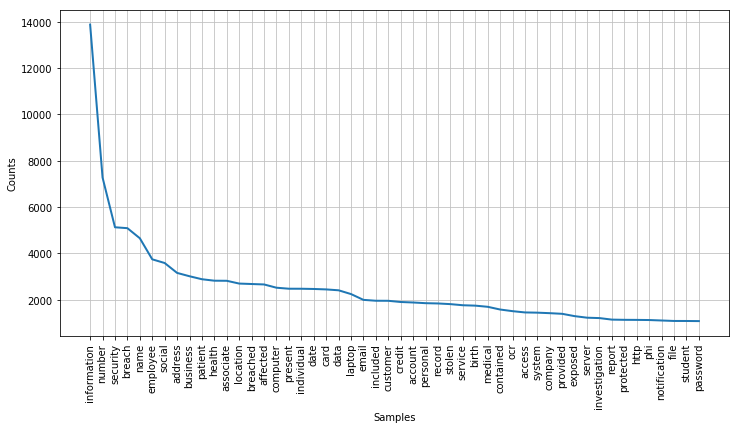

In [13]:
#graph of 50 most common words
plt.figure(figsize=(12,6))
fdist_DD.plot(50)

In [14]:
#bigrams
description_bgs = nltk.bigrams(description_data)

fdist_DD_bgs = nltk.FreqDist(description_bgs)
fdist_DD_bgs.most_common(50)

[(('social', 'security'), 3530),
 (('security', u'number'), 3463),
 (('business', 'associate'), 2723),
 (('breached', 'information'), 2436),
 (('location', 'breached'), 2430),
 (('associate', 'present'), 2429),
 ((u'date', 'birth'), 1504),
 (('personal', 'information'), 1337),
 ((u'name', u'address'), 1210),
 (('credit', 'card'), 1188),
 ((u'name', 'social'), 1139),
 (('health', 'information'), 1115),
 (('information', 'http'), 1023),
 (('protected', 'health'), 913),
 (('covered', 'entity'), 901),
 (('affected', u'individual'), 881),
 (('breach', 'notification'), 810),
 (('included', u'name'), 795),
 (('data', 'breach'), 681),
 (('medical', u'record'), 665),
 (('provided', 'breach'), 624),
 (('email', u'address'), 597),
 (('phone', u'number'), 594),
 ((u'number', u'date'), 579),
 (('notification', 'hhs'), 569),
 (('paper', u'film'), 557),
 ((u'film', 'business'), 518),
 (('card', u'number'), 512),
 (('information', 'compromised'), 512),
 (('human', u'service'), 503),
 (('information', 

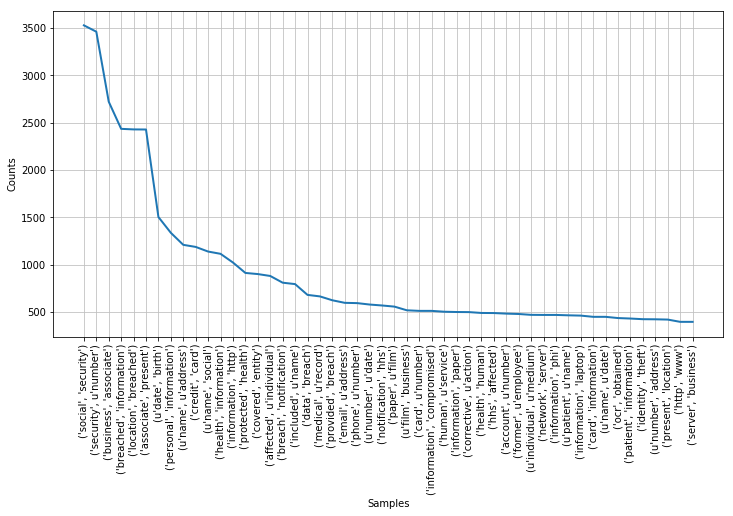

In [15]:
#graph of 50 most common bigrams
plt.figure(figsize=(12,6))
fdist_DD_bgs.plot(50)

## Topic Modeling

In [22]:
#convert to pandas    
description_data_DF = pd.DataFrame(description_data)

In [11]:
#Dictionary Creation
# this is text processing required for topic modeling with Gensim
dictionary = Dictionary(description_data)
len(dictionary)

14333

In [12]:
#Corpus Creation
# this is text processing required for topic modeling with Gensim
corpus = [dictionary.doc2bow(text) for text in description_data]

In [ ]:
#save the dictionary & corpus
#dictionary.save('Topic_Modeling/Data_Breaches.dict')  # store the dictionary, for future reference
#corpora.MmCorpus.serialize('Topic_Modeling/Data_Breaches.mm', corpus)  # store to disk, for later use  # store to disk, for later use

### LDA Model

In [85]:
#find optimal k value
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

#use a range of 2-10 topics
for k in range(2,10):
    goodLdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=50)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print goodcm.get_coherence()

-1.2427417218556287
-1.317805550892574
-1.6596051776016822
-1.7415097315061872
-1.8159969659489796
-1.72486603004232
-1.6720838116783263
-1.766338164616869


#### 2 topic has the lowest value (-1.24) and is therefor the ideal number of topics.

In [17]:
#Create LDA Topic Model for 2 topics
ldamodel = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, passes=20)

In [18]:
#list model topics
ldamodel.show_topics()

[(0,
  u'0.035*"information" + 0.025*"number" + 0.016*"security" + 0.014*"name" + 0.012*"social" + 0.011*"employee" + 0.011*"card" + 0.011*"address" + 0.010*"customer" + 0.009*"breach"'),
 (1,
  u'0.043*"information" + 0.023*"business" + 0.022*"breach" + 0.022*"associate" + 0.021*"health" + 0.020*"location" + 0.019*"breached" + 0.018*"present" + 0.014*"individual" + 0.014*"patient"')]

#### Topic 1 contains a terms that are related to specific types of information that were breached. 
#### Topic 2 is oriented towards organization types.

### LSI Model

In [23]:
#LSI Model
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

lsimodel = LsiModel(corpus=corpus, num_topics=2, id2word=dictionary)

In [24]:
# Show  topics
lsimodel.show_topics()  

[(0,
  u'0.555*"information" + 0.282*"number" + 0.264*"breach" + 0.214*"security" + 0.165*"name" + 0.144*"health" + 0.137*"employee" + 0.133*"individual" + 0.127*"affected" + 0.125*"social"'),
 (1,
  u'0.273*"card" + 0.239*"number" + -0.224*"associate" + -0.220*"business" + -0.208*"ocr" + -0.203*"health" + 0.190*"customer" + -0.189*"individual" + 0.164*"credit" + -0.163*"present"')]

#### Topic 1 struggle to find a specific topic from these terms. Its a very generic data breach topic.
#### Topic 2 This topic contains terms about specific information that may have been breached and possible from whom.

The LDA model is much slower to train than the LSI model but appears to have a higher accuracy.  The LDA models terms were more organized that the LSI ones which were much more disconnected.

### Classifier Modeling

For the classifer modeling, I decided to try a new approach.  I'm going to use Azure Machine Learning studio (AZML). https://studio.azureml.net/ .  AZML is a different technique that doesn't require any advanced coding but instead uses individual function nodes and wiring to show data flows.  It contains multiple classification algorithms as well as data cleaning nodes and model evaluation.  Using this system, I found it much easier to run multiple algorithms against each other and compare the outputs.  It also has the ability to easily convert a trained model into a web service for easy production use.

The basic steps are the same to using a programming languaged based system
    1. Create/Upload datasets
    2. Clean/process the datasets
    3. Split the data into training/testing sets
    4. Train models
    5. Evaluate the models.



This is an example of the AZML page which is browser based.  You have the functions node selection on the left side, the workspace/data flow in the middle and node properties on the right hand side

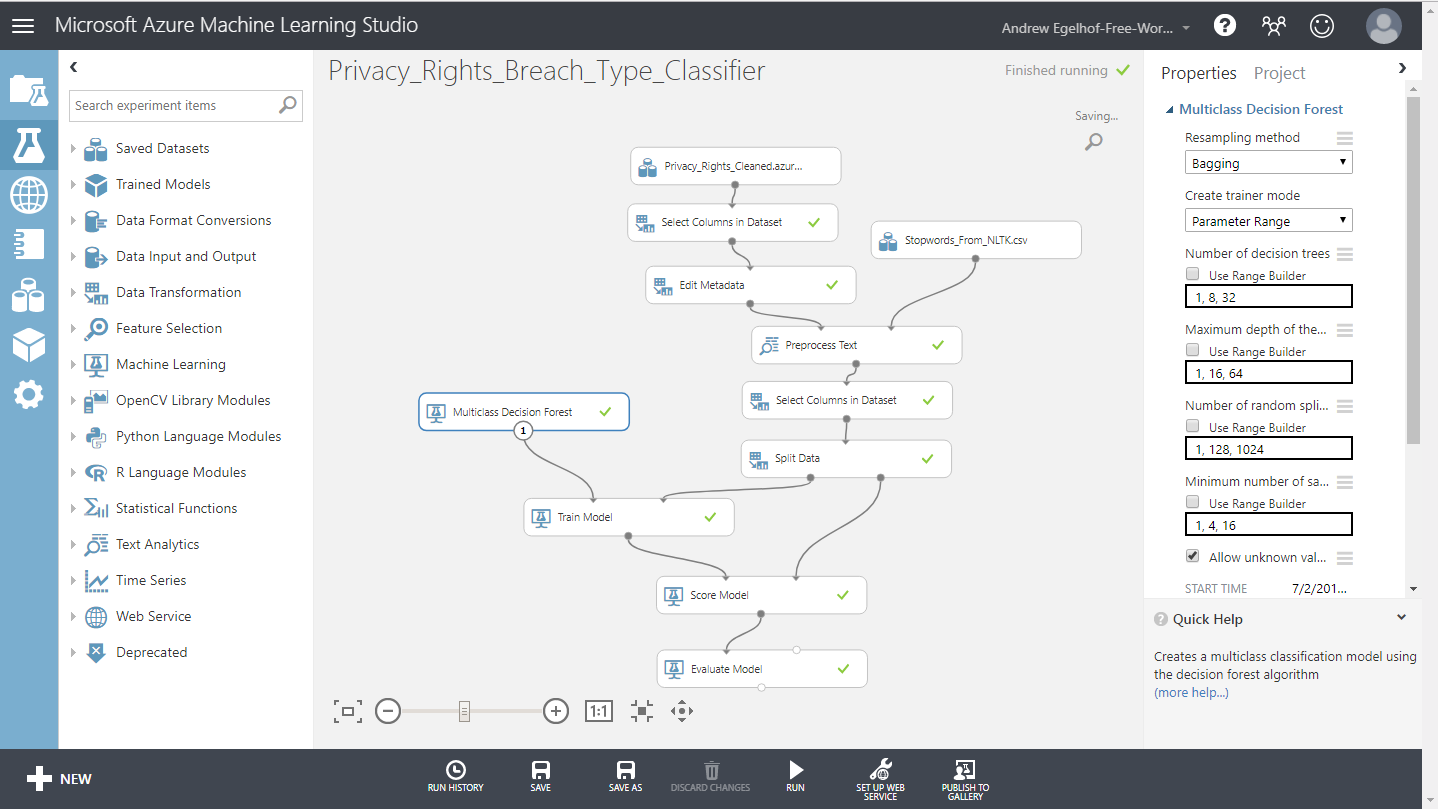

In [26]:
from IPython.display import Image
Image("img/AZML/Overall.png")

This shows the steps I took to train a multi classifier model.
    1. Import the dataset, which was already uploaded.  This is the same dataset from the cleaning steps prior to this.
    2. Select columns, remove columns were not going to use for the model.
    3. Edit Metadata, this node changes the datatype from a string to a categorical for "Type of Breach" and "Type of Organization".
    4a. This is an import of a second dataset, the Stop Words list from NLTK.  
    4b. Text Processing, this is a data cleaning step. It does cleaning and pre-processing like i did in topic modeling.  The steps are 1. remove stop words (from the attached NLTK dataset) 2. Lemmatization, 3. normalizes words to lowercase 4. removes numbers 5. removes special characters 6. Remove duplicated characters 7. Remove URLS 8. Expand verb contraction.
    5. Select columns, remove non-cleaned text column
    6. Split Data, this is the split to training & testing datasets.  I used 70% training and 30% testing.
    7a. Model selection, this is which model will be trained
    7b. Train Model, the actual model training.
    8. Score Model, this is where the model gets scored when compared with the testing dataset
    9. Evaluated Model, this is where it shows the metric of the score.
    
Because all of the steps except for selecting the model were the same to test a new model, it was easy to test multiple models by just replacing the one node a 7a.  You can also duplicate the 7b and 8. nodes and run another model in a parallel.


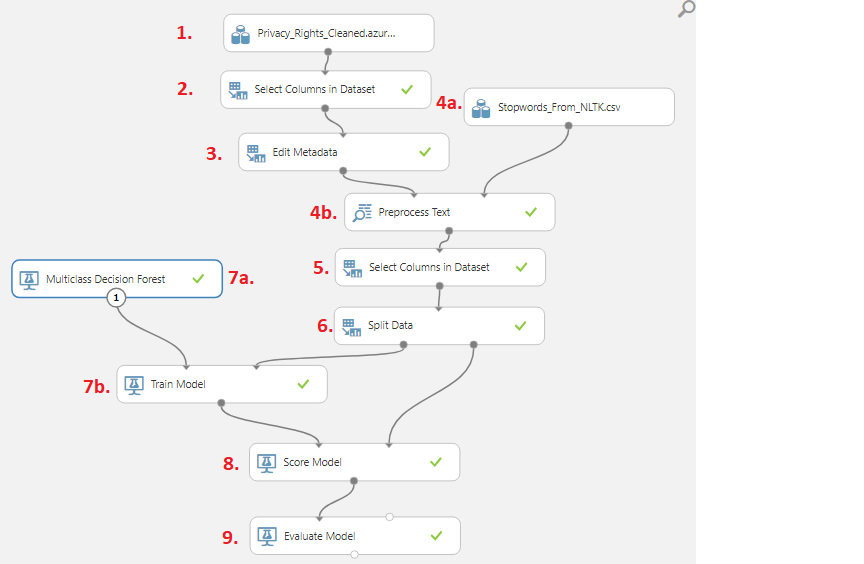

In [27]:
Image("img/AZML/model_training.png")

This is a closeup of the settings for the text processing step 4b.

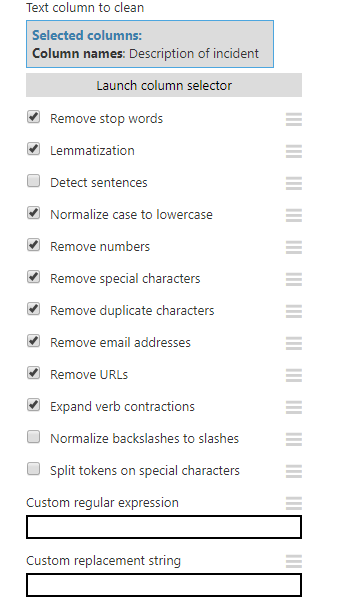

In [28]:
Image("img/AZML/text_processing.png")

This is the comparison of the models in parallel.

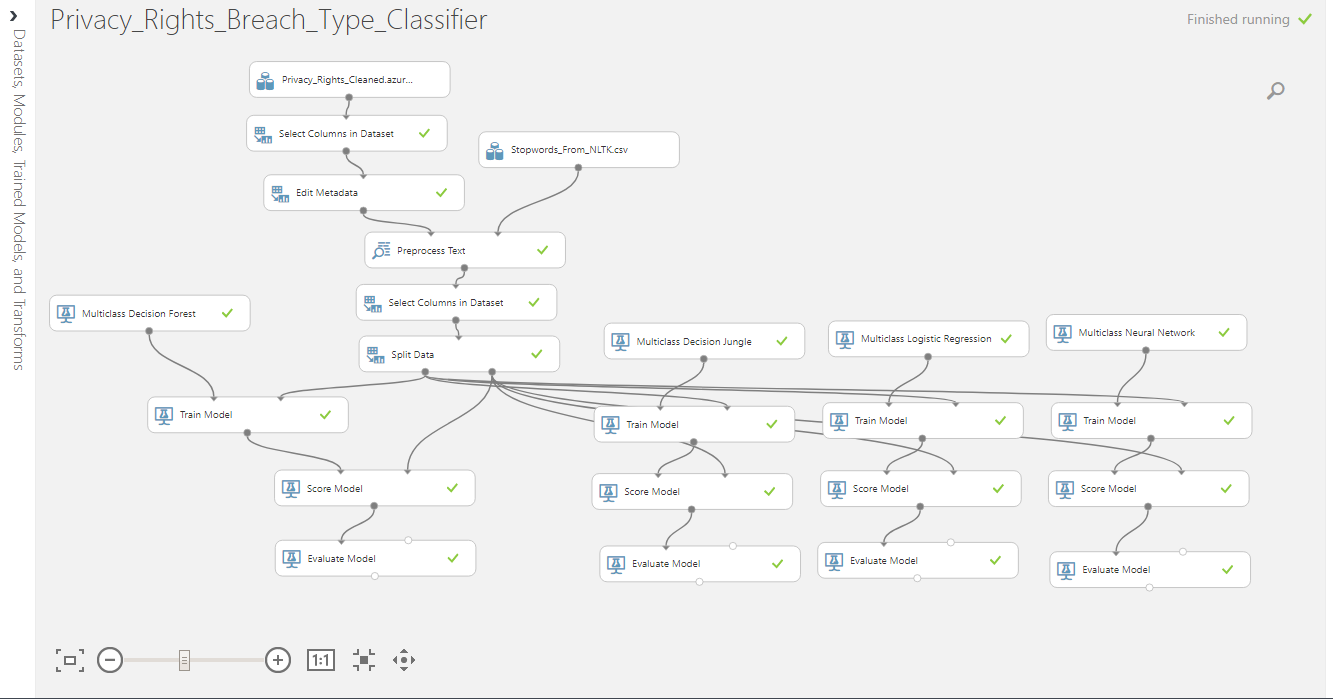

In [29]:
Image("img/AZML/multiple_models.png")

For predicting Breach Type, I trained basic models with default settings using the following algorithms and comparied the accuracy results.

"Type of Breach"

| Algorithm | Overall Accuracy|
|------|------|
|   Multiclass Decision Forrest  | 0.362|
|   Multiclass Decision Jungle  | 0.355|
|   Multiclass Logistic Regression  | 0.339|
|   Multiclass Neural Network  | 0.346|

These were all incredibly close to each other but Decision Forrest had the best overall accuracy of 0.362, but that is still very low.


This is the evauation results from the Decision Forrest algorithm.

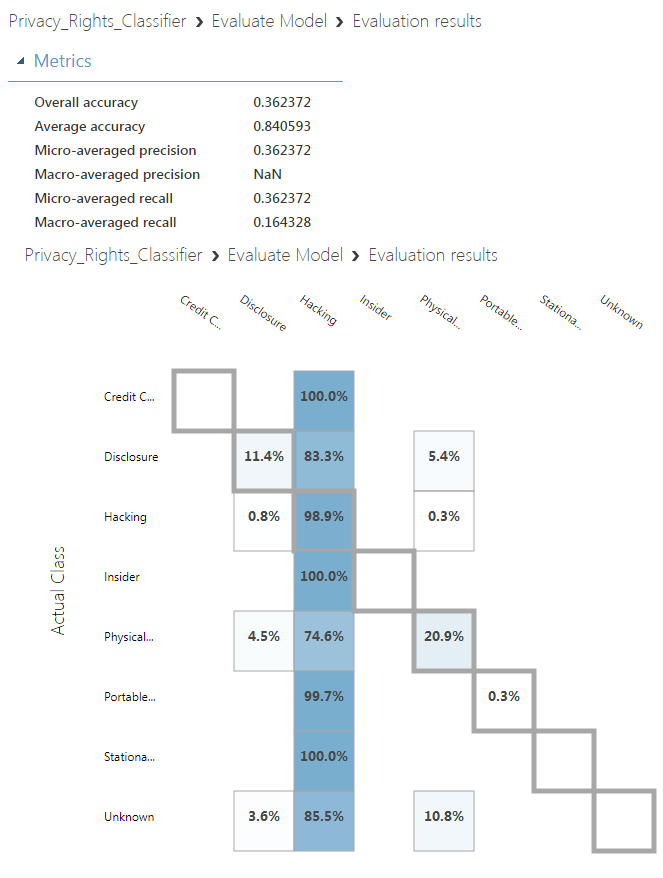

In [30]:
Image("img/AZML/type_of_breach_eval.png")

The same models are easily re-run for prediction the type of organization by changing the column selection in step 5. to Type of Organization instead of Type of Breach and then changing the train model node in step 7b. to predict Type of Organization".

Algorithm results for predicting "Type of Organization".


| Algorithm | Overall Accuracy|
|------|------|
|   Multiclass Decision Forrest  | 0.484|
|   Multiclass Decision Jungle  | 0.484|
|   Multiclass Logistic Regression  | 0.483|
|   Multiclass Neural Network  | 0.485|

The orgininal dataset contains 49% "medical provider" so the algorithms predict that result almost 99% of the time leading to that accuracy. So the models are overfitting.  Additonal work will be required to try to correct that.

This is the evauation results from the Decision Forrest algorithm.

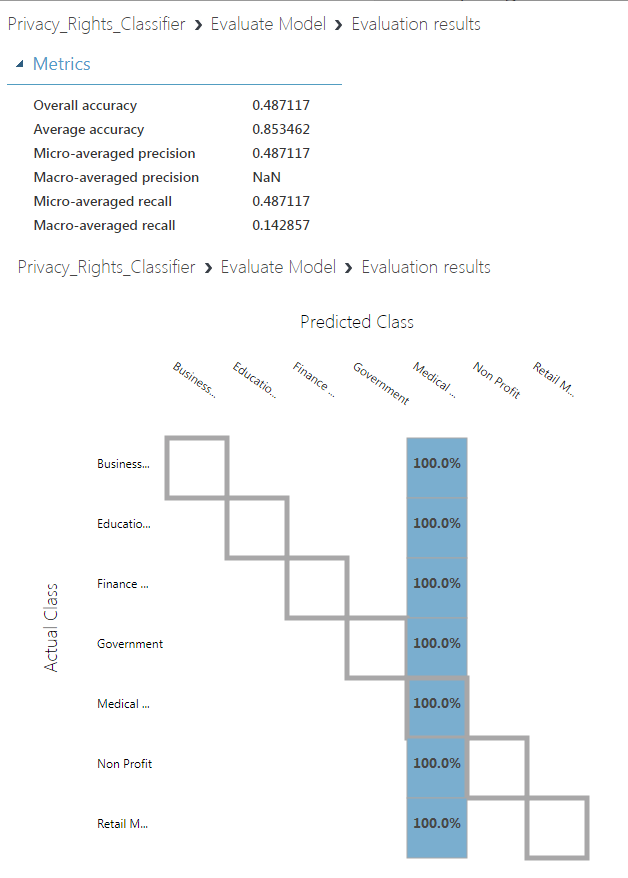

In [31]:
Image("img/AZML/type_of_org_eval.png")

## Classifer Modeling Evaluation and Enhancement

### Topic Modeling

Dr Chae suggested that I increase my topic numbers consdering the number of breach types in the dataset. I tried up to 10 topics and found that 8 seemed to produce the most competent topics.

In [48]:
#Create LDA Topic Model for 8 topics
ldamodel = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=8, passes=20)
#list model topics
ldamodel.show_topics()

[(0,
  u'0.029*"employee" + 0.022*"record" + 0.012*"information" + 0.011*"email" + 0.010*"department" + 0.010*"patient" + 0.008*"county" + 0.008*"sent" + 0.008*"attorney" + 0.008*"medical"'),
 (1,
  u'0.027*"information" + 0.024*"hacker" + 0.017*"password" + 0.016*"security" + 0.016*"user" + 0.016*"student" + 0.015*"address" + 0.014*"data" + 0.014*"number" + 0.013*"access"'),
 (2,
  u'0.047*"information" + 0.042*"laptop" + 0.041*"patient" + 0.034*"number" + 0.029*"name" + 0.025*"stolen" + 0.024*"date" + 0.024*"computer" + 0.021*"medical" + 0.020*"security"'),
 (3,
  u'0.057*"information" + 0.029*"breach" + 0.022*"card" + 0.019*"http" + 0.018*"customer" + 0.016*"number" + 0.014*"report" + 0.014*"compromised" + 0.014*"service" + 0.013*"unauthorized"'),
 (4,
  u'0.028*"breach" + 0.023*"information" + 0.023*"individual" + 0.018*"ocr" + 0.017*"business" + 0.017*"health" + 0.016*"associate" + 0.015*"phi" + 0.013*"provided" + 0.013*"affected"'),
 (5,
  u'0.098*"information" + 0.096*"breached"

1. Is centered around medical records
2. Is centered around hacking topics
3. Is centered around types of information stolen
4. I'm unable to determine a certain topic here.
5. Is centered around locations of lost information
6. Is also centered around types of information stolen
7. Is centered around credit card information and similar types of information.

### Classifier Modeling

For my classifier models, the evaluation methods were the same for both.  I used Accuracy as the main metric for all of the models to be compared against.  Precision and recall were also evaluated by were not weighted as heavily as accuracy.  I would also review the confusion matrix from each model after each training session to view how the model was making selections.

I iterated through many different ways of trying to improve the accuracy of the model and reduce the overfitting.  Ultimately, I found three different changes that when made together would accomplish those goals.

The first was removing additional words from the incident description.  I ran a quick word frequency report on that field and remove the top XX words that I felt would not help the model(s) determine the type or breach or organization type.  This was in addition to the already remove stop words from the NTLK library.

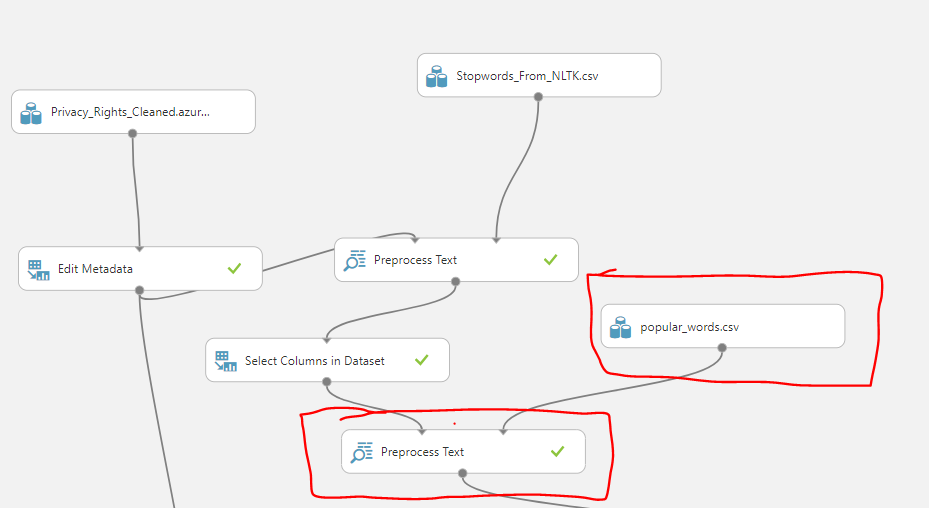

In [29]:
from IPython.display import Image
Image("img/AZML/enhance/remove_popular_words.PNG")

The second was to use the Latent Dirichlet Allocation (LDA) module to create additional categories from the original string text.  The LDA model would produce 7 or 8 additional topic fields and then give those fields weights.  Those additional fields would then be used to improve the models.

For predicting “Type of Breach” I used 8 topics and for “Type of Organization” I used 7 topics.  Those topics represented each of the categories in those fields.

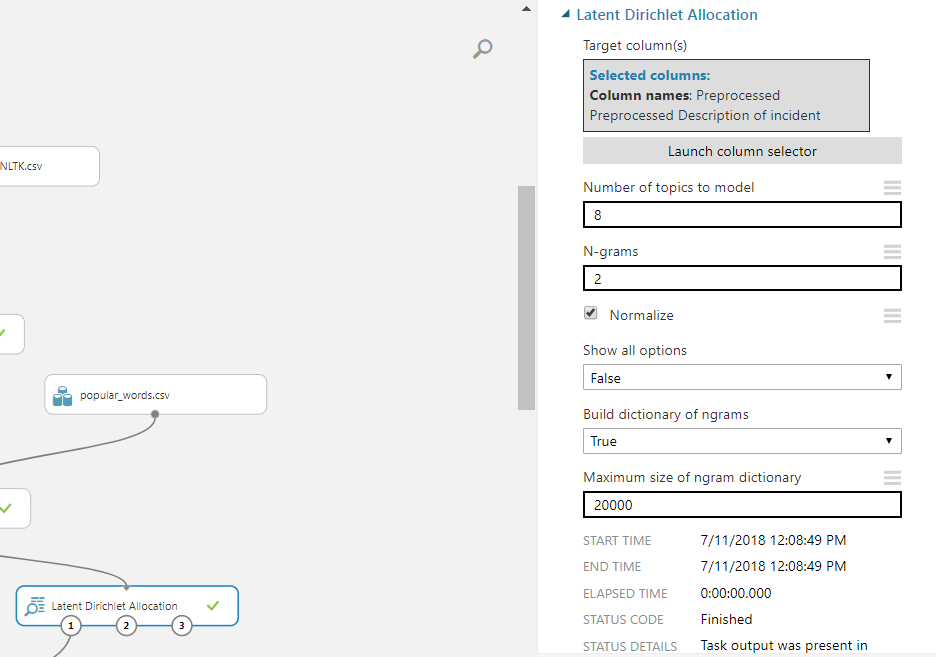

In [30]:
Image("img/AZML/enhance/LDA1.PNG")

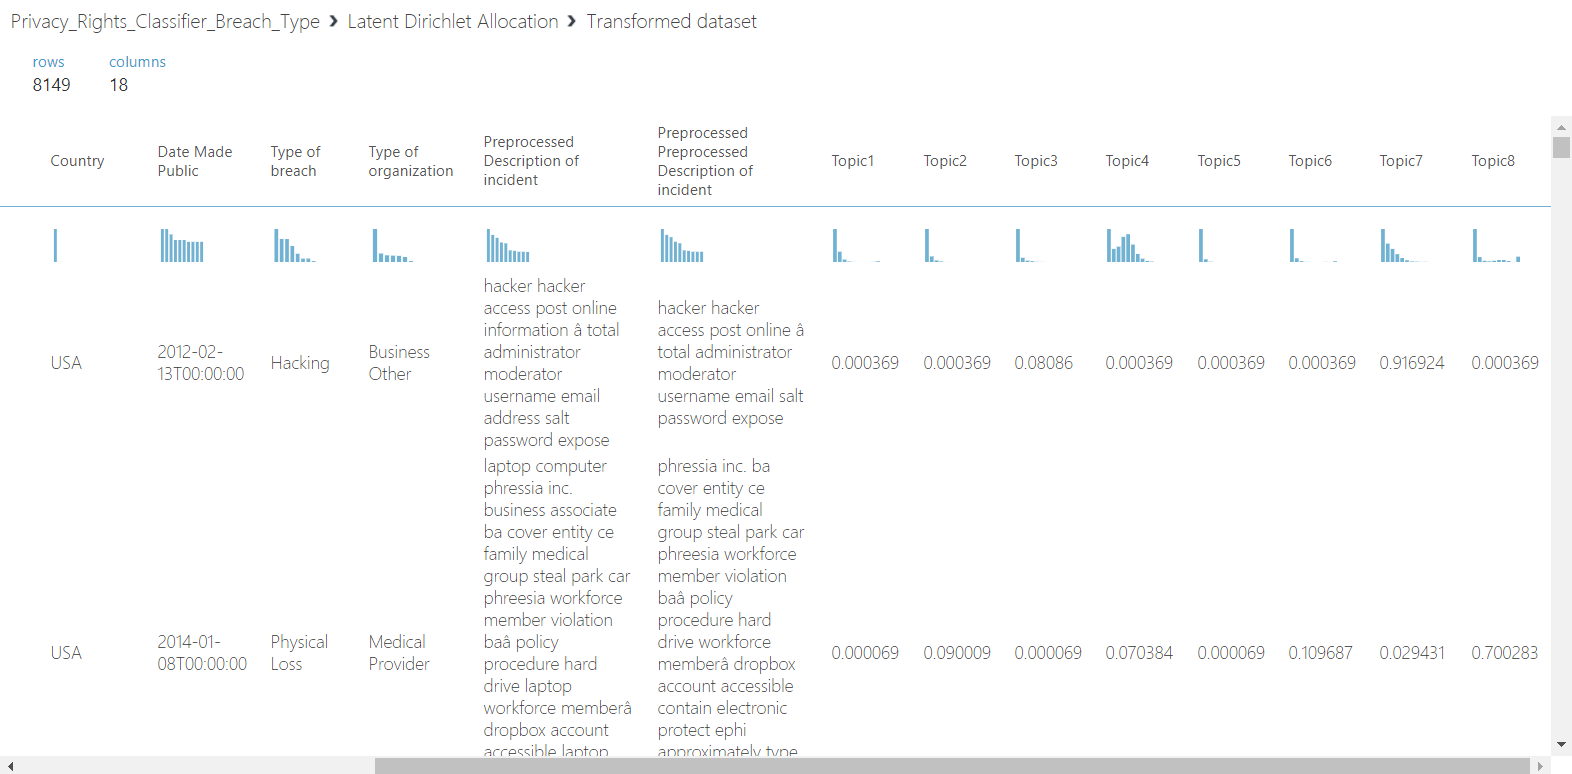

In [33]:
Image("img/AZML/enhance/LDA_output.PNG")

The third method for enhancing the model involved tweaking or tuning the parameters of each model.  Not being an expert at each model type, I wanted to test many iterations of each model type with different parameters on the same data.  So I would set a range of parameters to try for each model and then use a grid sweep to test different combinations.  The Hyperparameters node would then produce the best trained model and show the results from the different iterations. 

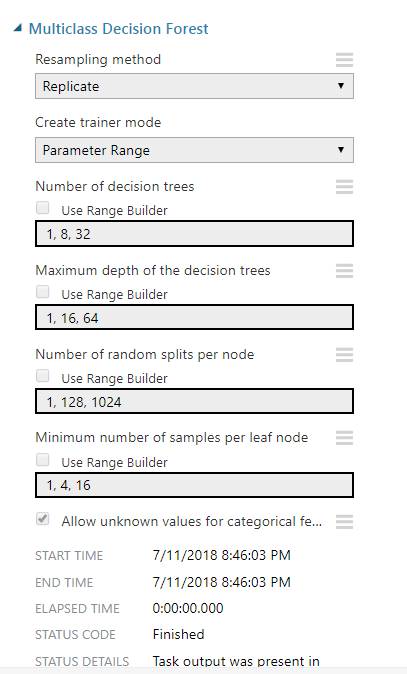

In [34]:
Image("img/AZML/enhance/MDF_parameters.PNG")

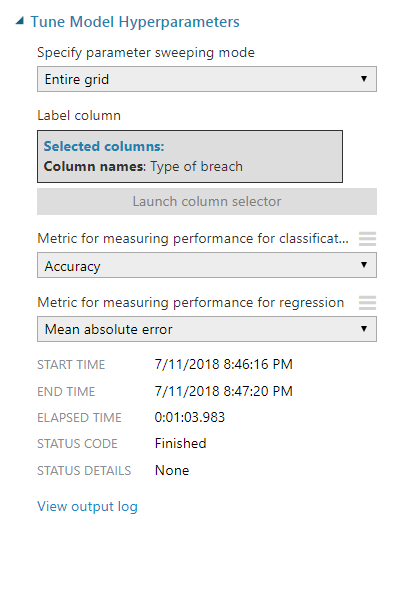

In [35]:
Image("img/AZML/enhance/hyperparameters.PNG")

The different models were then scored and evaluated as before.  This evaluation would produce an accuracy score and a confusion matrix.  With Azure ML you can compare up to two models at a time.  I would compare two and then compare two more, keeping track of the accuracy scores.  I would then review the results together and decide which model I liked the best.

This is an example of a comparison of the output of two models.  These are actually the same algorithm but the one one the right includes the LDA topic features and the text processing of the string feature.

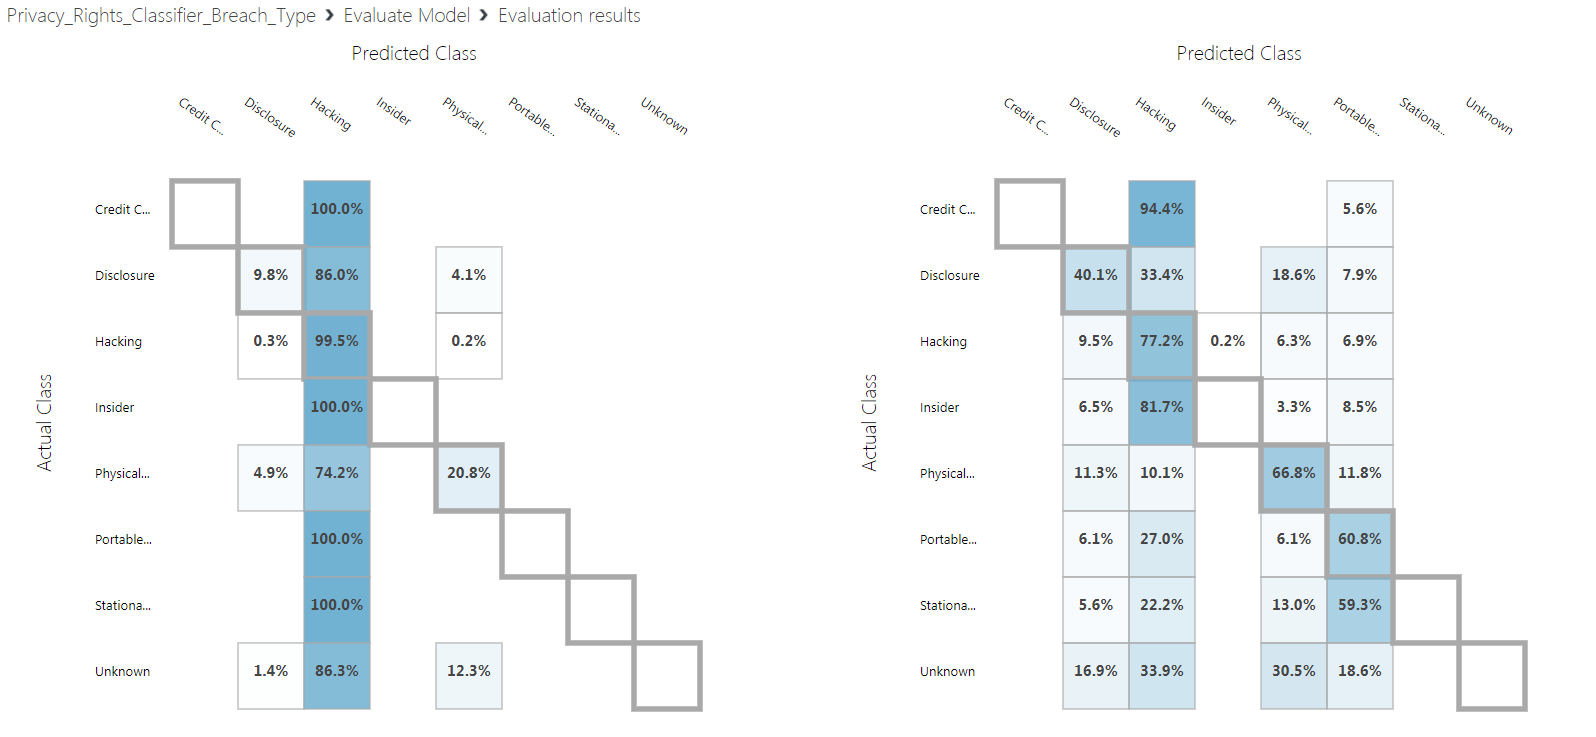

In [36]:
Image("img/AZML/enhance/model_comparison_confusion_matrix.PNG")

I would then use a Cross Validation model for additonal validation of model performance.

These are the results of the type of breach algorithms.

The Multiclass Decision Forrest performed in the best of the traning runs but Multiclass Logistic Regression was best with the cross-validate.

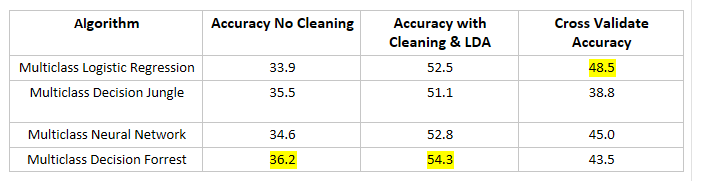

In [39]:
Image("img/AZML/enhance/type_of_breach_results.PNG")

This shows the different in the two models the left side is the before the text cleaning, LDA topic features and hyper paramter turning and the right is after.  The final model is still overfit a bit but the affect is not as pronounced.

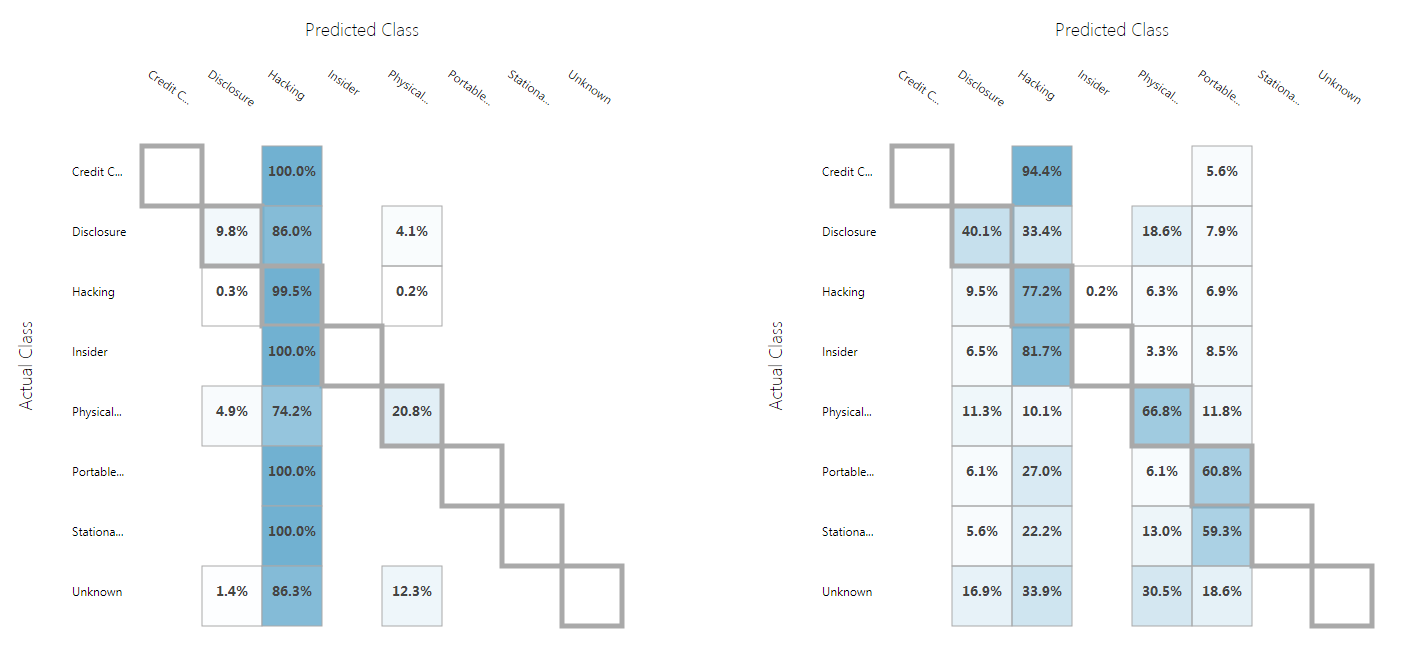

In [40]:
Image("img/AZML/enhance/type_of_breach_comparison_matrix.PNG")

These are the results of the type of organization algorithms.

The Multiclass Decision Neural Network was the general winner with Multiclass Lgoistic Regression being the best using Cross Validation

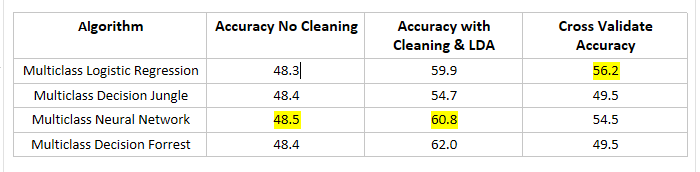

In [42]:
Image("img/AZML/enhance/type_of_org_results.PNG")

Again, this shows the different in the two models the left side is the before the text cleaning, LDA topic features and hyper paramter turning and the right is after.  The final model is also still overfit a but the predictions are much more 

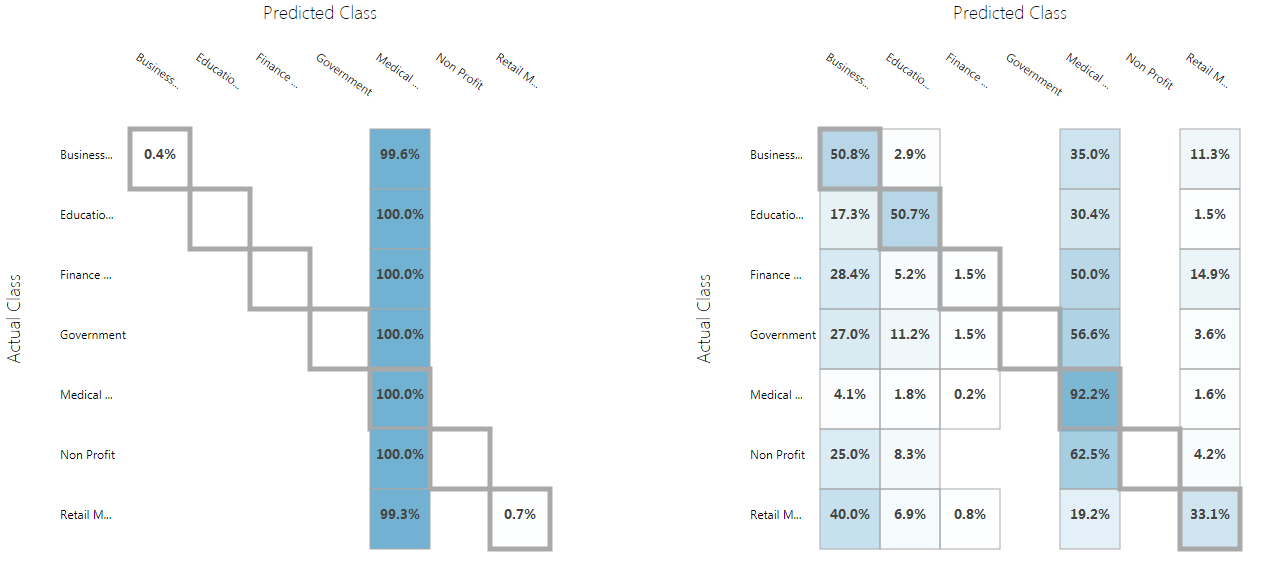

In [44]:
Image("img/AZML/enhance/type_of_org_comparison_matrix.PNG")